04_feature_engineering

In [1]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
import os
from pathlib import Path

In [2]:
#Loading data from csv file
df = pd.read_csv("../data/cleaned/cleaned_data.csv", parse_dates=["Date"])

In [3]:
# Define relative path using pathlib
output_path = Path("../images/feature_engineering")
output_path.mkdir(parents=True, exist_ok=True)

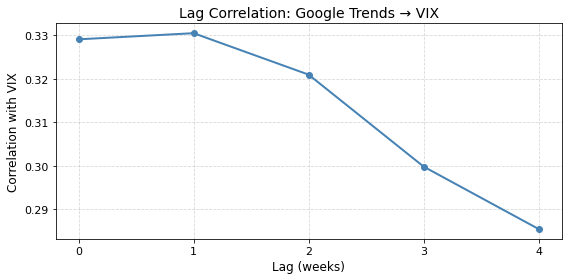

In [4]:
#Lag Correlation (Google Trends → VIX)

# Compute lag correlations
lags = range(0, 5)
correlations = []

for lag in lags:
    shifted = df["Google_Sentiment_Index"].shift(lag)
    corr = shifted.corr(df["VIX_Close"])
    correlations.append(corr)

# ✅ Plot with consistent styling
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(lags, correlations, marker='o', color='steelblue', linewidth=2)

ax.set_title("Lag Correlation: Google Trends → VIX", fontsize=14, color='black')
ax.set_xlabel("Lag (weeks)", fontsize=12, color='black')
ax.set_ylabel("Correlation with VIX", fontsize=12, color='black')

ax.tick_params(axis='x', colors='black', labelsize=11)
ax.tick_params(axis='y', colors='black', labelsize=11)

ax.set_xticks(lags)
ax.grid(True, linestyle='--', alpha=0.5)

fig.tight_layout()

# ✅ Saving
# Saving
fig.savefig(output_path / "lag_correlation_google_vix.png", dpi=300, bbox_inches="tight", facecolor='white') 

# Displaying
plt.show()


In [5]:
# Prepare the data
granger_df = df[["VIX_Close", "Google_Sentiment_Index"]].dropna()

In [6]:
# Run Granger test: Does Google Sentiment "cause" VIX?
print("Granger Causality Test Results (max lag = 4)")
grangercausalitytests(granger_df, maxlag=4, verbose=True)

Granger Causality Test Results (max lag = 4)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2134  , p=0.0128  , df_denom=1115, df_num=1
ssr based chi2 test:   chi2=6.2301  , p=0.0126  , df=1
likelihood ratio test: chi2=6.2128  , p=0.0127  , df=1
parameter F test:         F=6.2134  , p=0.0128  , df_denom=1115, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1873  , p=0.0021  , df_denom=1112, df_num=2
ssr based chi2 test:   chi2=12.4303 , p=0.0020  , df=2
likelihood ratio test: chi2=12.3617 , p=0.0021  , df=2
parameter F test:         F=6.1873  , p=0.0021  , df_denom=1112, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.4976  , p=0.0002  , df_denom=1109, df_num=3
ssr based chi2 test:   chi2=19.6157 , p=0.0002  , df=3
likelihood ratio test: chi2=19.4453 , p=0.0002  , df=3
parameter F test:         F=6.4976  , p=0.0002  , df_denom=1109, df_num=3

Granger Causality
number of lags (no zero)

C:\Users\melny\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (6.2133589131192615, 0.012823235712380475, 1115.0, 1),
   'ssr_chi2test': (6.230076470733034, 0.012559831237664649, 1),
   'lrtest': (6.212782079481258, 0.012683115020692871, 1),
   'params_ftest': (6.213358913119481, 0.012823235712378813, 1115.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (6.187334217486857, 0.0021267500485118284, 1112.0, 2),
   'ssr_chi2test': (12.430309929735287, 0.0019989065661174966, 2),
   'lrtest': (12.361654701626321, 0.0020687155928893804, 2),
   'params_ftest': (6.187334217487093, 0.0021267500485114524, 1112.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (6.497552810924318, 0.00023340927020796244, 1109.0, 3),
   'ssr_chi2test': (19.615695952186307, 0.00020389182404432541, 3),
   'lrtest': (19.445299269592397, 0.00022114431206674283, 3),
   'params_ftest': (6.4975528109242875, 0.00023340927020796244, 1109.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 

In [7]:
# 🎯 Target variable
df["Target_NextWeekDrop"] = (df["SP500_Returns"].shift(-1) < 0).astype(int)

In [8]:
# ➕ Add Lag Features
df["Mood_Index_Lag1"] = df["Mood_Index"].shift(1)
df["SP500_Returns_Lag1"] = df["SP500_Returns"].shift(1)
df["VIX_Change_Lag1"] = df["VIX_Change"].shift(1)
df["Google_Trend_Lag1"] = df["Google_Sentiment_Index"].shift(1)
df["Unemployment_Lag1"] = df["Unemployment"].shift(1)

In [9]:
# 🚿 Drop NA
df_model = df.dropna(subset=[
    "Mood_Index", "Mood_Index_Lag1",
    "SP500_Returns_Lag1", "VIX_Change_Lag1",
    "Google_Trend_Lag1", "Unemployment_Lag1",
    "Target_NextWeekDrop"
]).copy()

In [10]:
# ✨ Features
features = [
    "Mood_Index", "Mood_Index_Lag1",
    "SP500_Returns_Lag1", "VIX_Change_Lag1",
    "Google_Trend_Lag1", "Unemployment_Lag1"
]

X = df_model[features]
y = df_model["Target_NextWeekDrop"]


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)